# Written on 2024.05.25

This notebook is used to perform the performance test on the trained model in each fold using the testing data extracted from the original dataset.

Since the trained models per folds have been exported previously, such models will be imported here to obtain the ROC curve, its AUC and all the associated metrics to evaluate the assessment of the model.

In [30]:
import sys
path = "/content/EEGNET"
sys.path.append(path)

In [35]:
!pip install pyyaml h5py

In [1]:
# Filesystem
import os
import zipfile

# data processing
import numpy as np
import pandas as pd

# AI-related
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
import itertools
#library for cross validation
from sklearn.model_selection import StratifiedKFold

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

#EEGNET
#from EEGModels import EEGNet
#from tensorflow.keras import utils as np_utils
#from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras import backend as K


## 1.1 Function to plot Confusion Matrix

In [2]:
def plot_confusion_matrix (cm,
                           classes,
                           normalize = False,
                           title = 'Confusion Matrix',
                           cmap=plt.cm.Greens
                          ):
  plt.imshow (cm, interpolation='nearest', cmap=cmap)
  plt.title (title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")
  print(cm)

  thresh = cm.max()*0.80
  for i, j in itertools.product (range(cm.shape[0]), range(cm.shape[1])):
     plt.text(j, i, round(cm[i,j],2),
              horizontalalignment="center",
              color="white" if cm [i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')

## 1.3 Function to normalize EEG data (run inside the loop to assemble the tensor)

In [3]:
def normalize_channels (data, n_channels):
  data_norm = np.zeros_like(data, dtype='float32')
  for ch in range (n_channels):
      min_val = (np.min(data[ch]))
      max_val = (np.max(data[ch]))
      data_norm [ch] = (data[ch] - min_val) / (max_val - min_val)

  return data_norm

# 2. Load data

## 2.1 Unzip testing dataset

In [4]:
local_zip = "/content/ERP_Pretest_Data_128Hz.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/content/ERP_Pretest_Data_128_Hz")
zip_ref.close()

## 2.2 Define file path

In [5]:
data_path = "/content/ERP_Pretest_Data_128_Hz/Test/"

## 2.3 Load file list

In [6]:
testlist = open  ("/content/ERP_Pretest_Data_128_Hz/TestFileList.txt", "r")
data = testlist.read()
test_data_files = data.split("\n")

In [7]:
test_data_files

['/content/ERP_Pretest_Data_128_Hz/Test/AMT002_PT_proc_tr_01.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT002_PT_proc_tr_06.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT002_PT_proc_tr_12.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT002_PT_proc_tr_19.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT002_PT_proc_tr_26.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT002_PT_proc_tr_31.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT002_PT_proc_tr_36.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT002_PT_proc_tr_43.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT002_PT_proc_tr_48.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT002_PT_proc_tr_55.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT002_PT_proc_tr_60.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT003_PT_proc_tr_05.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT003_PT_proc_tr_10.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT003_PT_proc_tr_15.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT003_PT_proc_tr_20.c

## 2.4 Determine the number of trials available based on the number of files

In [8]:
n_trials_test = len(test_data_files)

# 2.5 Information from the trials.

In [9]:
n_channels = 20
n_samples = 128
n_kernels = 1

# 2.6 Generate container for the data

In [10]:
X_test = np.zeros ((n_trials_test, n_channels, n_samples), dtype='float32')

In [11]:
n_trials_test

231

In [12]:
X_test.shape

(231, 20, 128)

# 2.7 Load trials in container

In [13]:
trial = 0
for filename in test_data_files:
  data = pd.read_csv(filename, header=None, dtype=np.float32)
  data_n = normalize_channels(np.array(data, dtype='float32'), n_channels)
  X_test[trial::] = np.array(data_n, dtype=np.float32)
  trial = trial+1

In [14]:
X_test

array([[[9.8025680e-01, 8.7502074e-01, 8.6841995e-01, ...,
         5.9699178e-02, 9.2528919e-03, 0.0000000e+00],
        [7.6728874e-01, 7.3349506e-01, 8.1919241e-01, ...,
         1.3135131e-01, 6.8457454e-04, 0.0000000e+00],
        [9.3654561e-01, 8.5419130e-01, 9.0316385e-01, ...,
         1.2632947e-01, 2.0321280e-02, 0.0000000e+00],
        ...,
        [4.9553004e-01, 4.0653220e-01, 4.6705240e-01, ...,
         2.6089582e-01, 8.2126006e-02, 1.0363337e-01],
        [5.3542203e-01, 5.6742328e-01, 6.1166137e-01, ...,
         1.3510050e-01, 1.2075242e-01, 6.9778509e-02],
        [4.6457794e-01, 4.3257669e-01, 3.8833863e-01, ...,
         8.6489952e-01, 8.7924755e-01, 9.3022150e-01]],

       [[3.4948209e-01, 3.8691401e-01, 3.6875388e-01, ...,
         7.5036895e-01, 6.4339435e-01, 5.7500416e-01],
        [4.9390307e-01, 5.1497960e-01, 4.4854021e-01, ...,
         8.0606955e-01, 6.2307835e-01, 4.7400820e-01],
        [3.4633297e-01, 3.8327152e-01, 3.5434568e-01, ...,
         7.649

# 2.8 Load test data labels

In [15]:
labels_path = '/content/ERP_Pretest_Data_128_Hz/TestLabels.csv'
y_test = np.array(pd.read_csv(labels_path, header=None, dtype='uint8'))
y_test = np.squeeze(y_test.T)

In [16]:
y_test

array([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

# 3 Load Models

# 3.1 Unzip model folder

In [17]:
local_zip = "/content/EEGNET_Models.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/content/EEGNET_Models")
zip_ref.close()

## 3.2 Define file path

In [18]:
data_path = "/content/EEGNET_Models/"

## 3.3 Load file list

In [19]:
modellist = open  ("/content/EEGNET_Models/ModelsList.txt", "r")
models = modellist.read()
model_files = models.split("\n")

In [20]:
model_files

['/content/EEGNET_Models/EEGNET_model_fold_0.h5',
 '/content/EEGNET_Models/EEGNET_model_fold_1.h5',
 '/content/EEGNET_Models/EEGNET_model_fold_2.h5',
 '/content/EEGNET_Models/EEGNET_model_fold_3.h5',
 '/content/EEGNET_Models/EEGNET_model_fold_4.h5',
 '/content/EEGNET_Models/EEGNET_model_fold_5.h5',
 '/content/EEGNET_Models/EEGNET_model_fold_6.h5',
 '/content/EEGNET_Models/EEGNET_model_fold_7.h5',
 '/content/EEGNET_Models/EEGNET_model_fold_8.h5',
 '/content/EEGNET_Models/EEGNET_model_fold_9.h5']

# 4 ROC test

4.1 Import libraries for ROC curve assessment

In [28]:
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, roc_curve, auc

4.2 Iterate across all folds and generate plots and metrics

8/8 [==============================] - 0s 26ms/step
Confusion Matrix for Fold 0:
[[112  63]
 [ 26  30]]
8/8 [==============================] - 0s 29ms/step
Confusion Matrix for Fold 1:
[[114  61]
 [ 26  30]]
8/8 [==============================] - 0s 26ms/step
Confusion Matrix for Fold 2:
[[110  65]
 [ 25  31]]
8/8 [==============================] - 1s 49ms/step
Confusion Matrix for Fold 3:
[[105  70]
 [ 22  34]]
8/8 [==============================] - 1s 51ms/step
Confusion Matrix for Fold 4:
[[97 78]
 [21 35]]
8/8 [==============================] - 1s 48ms/step
Confusion Matrix for Fold 5:
[[116  59]
 [ 27  29]]
8/8 [==============================] - 0s 28ms/step
Confusion Matrix for Fold 6:
[[103  72]
 [ 23  33]]
8/8 [==============================] - 0s 25ms/step
Confusion Matrix for Fold 7:
[[105  70]
 [ 25  31]]
8/8 [==============================] - 0s 26ms/step
Confusion Matrix for Fold 8:
[[115  60]
 [ 27  29]]
8/8 [==============================] - 0s 26ms/step


Confusion Matrix for Fold 9:
[[108  67]
 [ 24  32]]


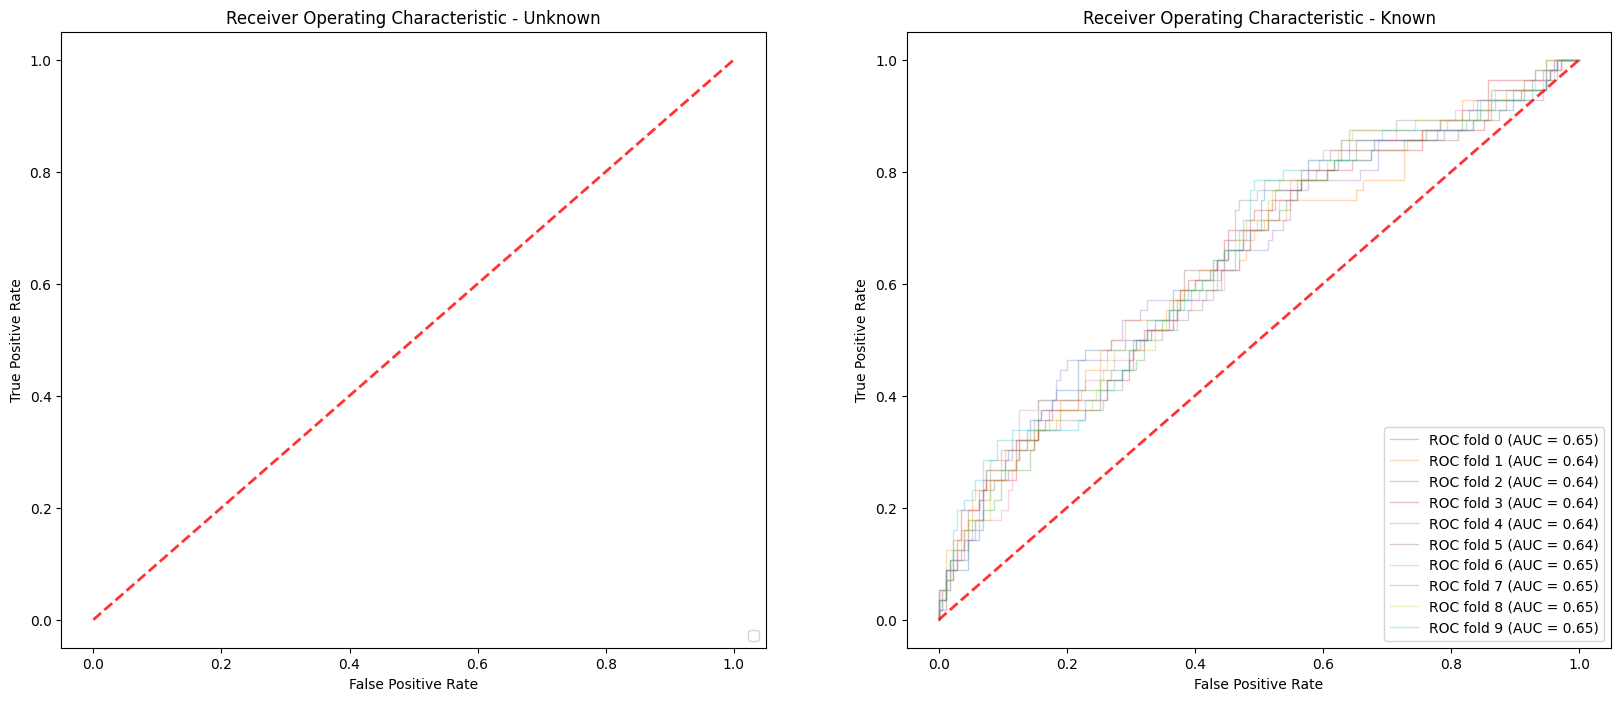

In [33]:
# import library for loading models from filesystem
from tensorflow.keras.models import load_model

# general data
#accuracies = []
#precisions = []
#recalls = []
#f1_scores = []

# data containers for unknown class
roc_aucs_unknown = []
tprs_unknown = []
mean_fpr_unknown = np.linspace(0, 1, 100)

# data containers for known class
roc_aucs_known = []
tprs_known = []
mean_fpr_known = np.linspace(0, 1, 100)

fold = 0
n_folds = 10

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

for filename in model_files:

  #import model into the loop
  EEGNET_Model = load_model (filename)

  # perform predictions on the testing data
  y_probs       = EEGNET_Model.predict(X_test)
  y_probs_unknown = y_probs[:, 0]
  y_probs_known = y_probs[:, 1]
  y_preds       = y_probs.argmax(axis = -1)

  # Confusion matrix for the current fold
  print(f'Confusion Matrix for Fold {fold}:')
  cm = confusion_matrix((y_test), y_preds)
  print(cm)
  #cm_plot_labels = ['Unknown', 'Known']
  #plot_confusion_matrix(cm, cm_plot_labels, normalize=False, title='Confusion Matrix')

  # General Metrics
  #accuracies.append(EEGNET_Model.score(X_test, y_test))
  #precisions.append(precision_score(y_test, y_preds, average='macro'))
  #ecalls.append(recall_score(y_test, y_preds, average='macro'))
  #1_scores.append(f1_score(y_test, y_preds, average='macro'))

  # ROC curve for Know class
  #RocCurveDisplay.from_estimator(
  #      EEGNET_Model,
  #     X_test,
  #      y_test,
  #      name=f"ROC fold {fold} Known",
  #      alpha=0.3,
  #      lw=1,
  #      ax=ax[0],
  #      plot_chance_level=(fold == fold - 1)
  #)

  # ROC curve for Unknown class
  fpr_u, tpr_u, _ = roc_curve(y_test, y_probs_unknown, pos_label=0)
  roc_auc_unknown = auc(fpr_u, tpr_u)
  roc_aucs_unknown.append(roc_auc_unknown)
  ax[0].plot(fpr_u, tpr_u, lw=1, alpha=0.3, label=f"ROC fold {fold} (AUC = {roc_auc_unknown:.2f})")

  # ROC curve for Known class
  fpr_k, tpr_k, _ = roc_curve(y_test, y_probs_known, pos_label=1)
  roc_auc_known = auc(fpr_k, tpr_k)
  roc_aucs_known.append(roc_auc_known)
  ax[1].plot(fpr_k, tpr_k, lw=1, alpha=0.3, label=f"ROC fold {fold} (AUC = {roc_auc_known:.2f})")


  fold = fold+1

#plot everything
ax[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic - Unknown')
ax[0].legend(loc='lower right')

ax[1].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic - Known')
ax[1].legend(loc='lower right')

plt.show()


In [58]:
  # perform predictions on the testing data
  y_probs       = EEGNET_model.predict(X_test)
  y_probs_unknown = y_probs [:,0]
  y_preds       = y_probs.argmax(axis = -1)

  y_probs

8/8 [==============================] - 0s 26ms/step


array([[0.1865744 , 0.8134262 ],
       [0.42672715, 0.57327384],
       [0.44869673, 0.55130684],
       [0.19811183, 0.80188966],
       [0.27135515, 0.7286447 ],
       [0.34883597, 0.6511673 ],
       [0.34093082, 0.6590716 ],
       [0.57304674, 0.42695588],
       [0.17403834, 0.8259627 ],
       [0.41962367, 0.5803795 ],
       [0.26083854, 0.7391643 ],
       [0.76150614, 0.23849559],
       [0.7940986 , 0.20590243],
       [0.6775688 , 0.32243353],
       [0.34428614, 0.65571684],
       [0.60862076, 0.39138183],
       [0.71354675, 0.28645518],
       [0.81871927, 0.18128142],
       [0.6376352 , 0.3623656 ],
       [0.5161705 , 0.48383126],
       [0.39749885, 0.6025035 ],
       [0.39192826, 0.6080731 ],
       [0.6108142 , 0.38918877],
       [0.79590565, 0.20409544],
       [0.83873874, 0.1612622 ],
       [0.7751679 , 0.22483264],
       [0.8424686 , 0.1575313 ],
       [0.6973205 , 0.30268174],
       [0.5044938 , 0.49550956],
       [0.81996185, 0.18003885],
       [0.

In [60]:
y_probs [:,1]

array([0.8134262 , 0.57327384, 0.55130684, 0.80188966, 0.7286447 ,
       0.6511673 , 0.6590716 , 0.42695588, 0.8259627 , 0.5803795 ,
       0.7391643 , 0.23849559, 0.20590243, 0.32243353, 0.65571684,
       0.39138183, 0.28645518, 0.18128142, 0.3623656 , 0.48383126,
       0.6025035 , 0.6080731 , 0.38918877, 0.20409544, 0.1612622 ,
       0.22483264, 0.1575313 , 0.30268174, 0.49550956, 0.18003885,
       0.0722335 , 0.7400688 , 0.18107212, 0.4114636 , 0.5231871 ,
       0.77477944, 0.5592856 , 0.22114721, 0.4594491 , 0.3272019 ,
       0.70130026, 0.63181967, 0.61616117, 0.5506539 , 0.49814445,
       0.5627537 , 0.4503186 , 0.63187337, 0.7566415 , 0.52767134,
       0.4202262 , 0.2726664 , 0.57544374, 0.28612435, 0.3683522 ,
       0.30854872, 0.5712888 , 0.27331164, 0.2511494 , 0.26543644,
       0.3330864 , 0.73291045, 0.6503245 , 0.81425256, 0.3450869 ,
       0.67997783, 0.19962193, 0.77949524, 0.70482075, 0.37713897,
       0.6290869 , 0.45202574, 0.70621485, 0.4845565 , 0.51353